In [59]:
import cv2
import torch
import urllib.request
import numpy
import matplotlib.pyplot as plt

vid = cv2.VideoCapture('videos/badminton.mp4')

In [46]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)


Using cache found in C:\Users\statix/.cache\torch\hub\intel-isl_MiDaS_master


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
midas.to(device)
midas.eval()

In [48]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in C:\Users\statix/.cache\torch\hub\intel-isl_MiDaS_master


In [49]:
print(midas_transforms)

<module 'midas.transforms' from 'C:\\Users\\statix/.cache\\torch\\hub\\intel-isl_MiDaS_master\\midas\\transforms.py'>


In [60]:
ret, img = vid.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)


In [51]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

dmap = prediction.cpu().numpy()


D:\btp\btp\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


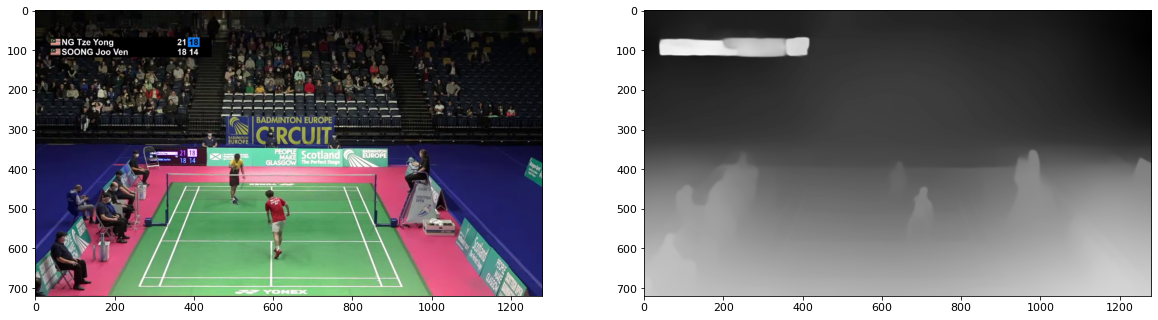

In [75]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(dmap,cmap='gray')

In [61]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to('cuda')

# Images
imgs = img

# Inference
results = model(imgs)

Using cache found in C:\Users\statix/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-12-22 torch 1.10.2+cu113 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [62]:
df = results.pandas().xyxy[0]
df

,xmin,ymin,xmax,ymax,confidence,class,name
0,578.968872,447.733795,644.710083,627.691284,0.861656,0,person
1,487.024506,357.169067,528.974060,489.394836,0.834869,0,person
2,38.295315,552.975891,141.314285,701.451477,0.756428,0,person
3,929.566406,351.848083,997.586060,455.609253,0.635879,0,person
4,153.424835,450.973175,245.222626,586.455750,0.603430,0,person
5,421.422882,307.154694,458.821503,345.119354,0.511162,0,person
6,81.089340,437.067749,145.695175,537.075684,0.471437,0,person
7,274.699982,342.819336,316.282684,398.874573,0.466861,56,chair
8,226.194427,352.293457,287.022003,446.185669,0.376877,0,person
9,487.677643,354.083466,529.514099,487.888275,0.350147,38,tennis racket


In [63]:
df['xmin'] = df['xmin'].astype(int)
df['ymin'] = df['ymin'].astype(int)
df['xmax'] = df['xmax'].astype(int)
df['ymax'] = df['ymax'].astype(int)
df = df.to_numpy()
df[:5]

array([[578, 447, 644, 627, 0.8616558909416199, 0, 'person'],
       [487, 357, 528, 489, 0.834868848323822, 0, 'person'],
       [38, 552, 141, 701, 0.7564284205436707, 0, 'person'],
       [929, 351, 997, 455, 0.635879397392273, 0, 'person'],
       [153, 450, 245, 586, 0.6034295558929443, 0, 'person']], dtype=object)

In [72]:
import numpy as np
bim = np.copy(img)
skim = np.zeros(dmap.shape)
for i in df:
    xmin,ymin,xmax,ymax,conf = i[:5]
    if conf>0.5:
        cv2.rectangle(bim,(xmin,ymin),(xmax,ymax),(0,180,255), 5)
        skim[ymin:ymax, xmin:xmax] = dmap[ymin:ymax, xmin:xmax]

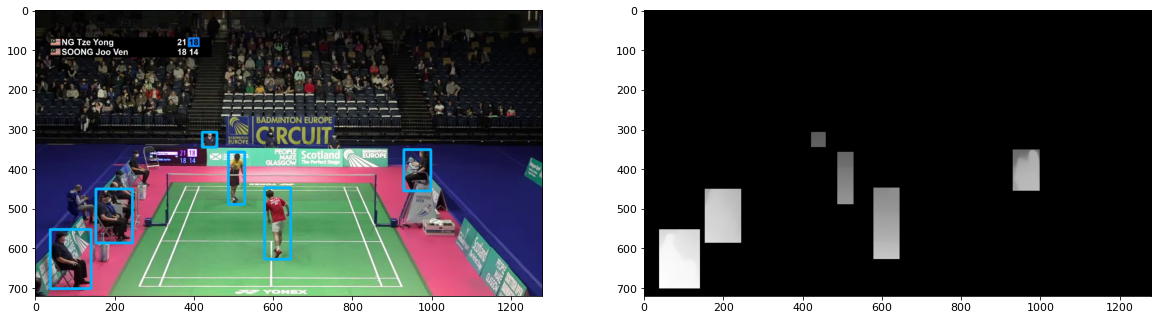

In [74]:
plt.figure(figsize=(20,15))
plt.subplot(121)
plt.imshow(bim)
plt.subplot(122)
plt.imshow(skim,cmap='gray')